# This is a particle - mesh N body gravity simulator. 

## Dependencies

Numpy and PyFFTW are dependencies for the bulk of calculations that allow this program to work efficiently. Matplotlib and VPython (soon to be replaced with visit) are dependencies for visualization. Scipy is currently unused, but it is expected that it will be used for regression of the results against expected theory.

In [1]:
# Python
from datetime import datetime

# MPL
import matplotlib        as mpl
import matplotlib.pyplot as plt

# VPython
import vpython        as vp

# NumPy
import numpy        as np
import numpy.random as random
import numpy.linalg as linalg
from numpy import cos, exp, log, pi, sin, sqrt

# SciPy
import scipy.fft as fft
import scipy.stats as stats
from scipy.optimize import curve_fit

# FFTW 0.12.0
# There currently exists a bug with conda-forge's builds of FFTW 0.13.0+.
# Version 0.12.0 requires python version 3.10.
import pyfftw

import time

<IPython.core.display.Javascript object>

We will be distributing particles randomly throughout space, but mostly we will be attempting to create spherical structures to investigate approximately spherically symmetric gravitational collapse. Therefore, we will need the ability to distribute random points in space parameterized by spherical coordinates. Given the non-uniform scale factors, a simple random.rand(N) does not suffice.

The volume element in spherical coordinates is given by $dV = r^2 \sin{\theta} dr d\theta d\phi$.
It isn't possible to straightforwardly generate a uniform probability distribution with these coordinates because of the nonlinear dependence of these coordinates in the volume element. 
However, we can cleverly change coordinates to linearize the volume element. 
$$u = -\cos{\theta} \rightarrow du = \sin{\theta}$$
$$\theta \in [0,\pi] \rightarrow u \in [-1,1]$$
$$v = \frac{1}{3} r^3 \rightarrow dv = r^2 dr$$
$$r \in [0,R] \rightarrow v \in [0,1/3 R^3]$$
Now we can generate a uniform probability distribution over these variables and convert them back to spherical coordinates to get our desired outcome.

In [3]:
def rand_r(N,r_min,r_max,rng=random.default_rng()):
    v_min = 1/3 * r_min**3
    v_max = 1/3 * r_max**3
    v = rng.uniform(v_min,v_max,N)
    return np.cbrt(3*v)

def rand_theta(N,theta_min,theta_max,rng=random.default_rng()):
    u_min = -cos(theta_min)
    u_max = -cos(theta_max)
    u = rng.uniform(u_min,u_max,N)
    return np.arccos(-u)

def rand_phi(N,phi_min,phi_max,rng=random.default_rng()):
    phi = rng.uniform(0,2*pi,N)
    return phi

According to the Particle-Mesh algorithm, we now map our spatial distribution of masses onto a $N_c \times N_c \times N_c$ discretized grid. Here we use $N_c = 128$. Particles are assigned to the grid according to a cloud-in-cell scheme, where each particle is assumed to be non-interacting but has finite size equivalent to that of each grid cell. The fraction of particle mass assigned to each cell is the fraction that each particle overlaps with that cell, among its 8 possible overlapping cells. 

Once we have a density field $\rho(x)$ approximated on a discrete grid as $\rho(x_{ijk})$, we can begin solving for its dynamics.
Gauss's law for gravity yields the Poisson equation for the gravitational potential field: $\nabla^2 \phi = 4\pi G \rho(x)$.
This can be solved using the Green's function for the Laplacian operator: $G(x,x')$ s.t. $\nabla^2 G(x,x') = \delta(x-x')$.
This is most easily done by first performing a Fourier transform on $G$. For now we will do everything on continuous space, and approximate later.
$$\nabla^2 G(x) = \nabla^2 \left( \frac{1}{(2\pi)^3} \int G(k) e^{i\vec{k}\cdot\vec{x}} d^3 k \right)$$
$$= \frac{1}{(2\pi)^3} \left( \int -\vec{k}^2 G(k) e^{i\vec{k}\cdot\vec{x}} d^3 k \right)$$
$$= \frac{1}{(2\pi)^3} \left( \int e^{i\vec{k}\cdot\vec{x}} d^3 k \right)$$
$$\implies G(k) = -\frac{1}{k^2}.$$
We could do an inverse Fourier transform to prove that $G(x,x') = -\frac{1}{4\pi |x-x'|}$, but we aren't using this result anyways.
For posterity, the real space solution to $\phi(x)$ using the real space Green's function is 
$$\phi(x) = \int \frac{-G \rho(x')}{|x-x'|} d^3 x' .$$
But this is more easily expressed and computed in Fourier space, where the convolution is just multiplication.
$$\tilde{\phi}(k) = \tilde{\rho}(k) \omega(k),$$
with $\omega(k) = \frac{-4\pi G}{k^2}$.

Our process to get the gravitational potential field will therefore be to perform a Fourier transformation on our density field $\rho$ at a given timestep, multiply it by this fixed kernel $\omega(k)$, and perform an inverse Fourier transformation on the product. 
For our discrete lattice with periodic conditions, we will have to make some adjustments.

First, we will need to perform a real-to-complex discrete Fourier transform on the density field. We will make an approximation for the $1/k^2$ term in the gravitational kernel so that it respects the periodic boundary conditions of the grid. This essentially replaces each component $k_i$ of $k$ with $\sin(k)$. And then we can perform a complex-to-real DFT on this result to get the potential field.

Finite difference operations for each axis of the potential field implements the gradient operator to give us the three spatial components of the force field.

In [199]:
# This class defines everything that has to do with the discretized simulation space.
# In doing so these class methods perform the bulk of the work for this simulation.
class Grid:
    def __init__(self, L, Nc, Np, Mp):
        # Basic properties of the simulation space.
        # Self-explanatory. Nc is a number of cells per side length.
        self.L = L
        self.Nc = Nc
        self.dl = L/Nc
        self.Np = Np
        self.Mp = Mp
        
        # Array that stores the overlap between particles and grid cells.
        # CIC[0] and [1] store indices of lower and upper x boundaries (i1 and i2)
        # [2-3] and [4-5] store corresponding indices for y and z boundaries.
        # [6] and [7] store proportions of particle width contained in cells i1 and i2 (dx1 and dx2)
        # [8-9] and [10-11] store corresponding values for y and z.
        self.CIC_inds = np.empty((6,Np), dtype=int)
        self.CIC_props = np.empty((6,Np))
        
        # Memory-aligned arrays to store density field, potential field, and intermediate momentum representations.
        self.rhos = pyfftw.empty_aligned((Nc,Nc,Nc), dtype='float64')
        self.kspace = pyfftw.empty_aligned((Nc,Nc,Nc//2+1), dtype='complex128')
        self.phis = pyfftw.empty_aligned((Nc,Nc,Nc), dtype='float64')

        # Arrays to store derivatives of the potential field.
        self.fxs = np.empty((Nc,Nc,Nc))
        self.fys = np.empty((Nc,Nc,Nc))
        self.fzs = np.empty((Nc,Nc,Nc))

        # planA computes a forward DFT, used for transforming density field to k-space.
        # planB computes a backward DFT, used for transforming convolution to the potential field.
        self.planA = pyfftw.FFTW(self.rhos, self.kspace, axes=(0,1,2), direction='FFTW_FORWARD', flags=['FFTW_MEASURE','FFTW_DESTROY_INPUT'])
        self.planB = pyfftw.FFTW(self.kspace, self.phis, axes=(0,1,2), direction='FFTW_BACKWARD', flags=['FFTW_MEASURE','FFTW_DESTROY_INPUT'])

        # Compute the gravitational kernel to implement the Poisson equation in k-space.
        w = lambda i,j,k : -4 * pi * G / ((2*sin(i*pi/Nc))**2 + (2*sin(j*pi/Nc))**2 + (2*sin(k*pi/Nc))**2)
        with np.errstate(divide='ignore'):
            self.wk = np.fromfunction(w, (Nc,Nc,Nc//2+1))
        self.wk[0,0,0] = 0

    # For internal use and testing use only.
    # Transforms real-space density field to complex momentum-space representation.
    def fft(self):
        return self.planA()
    
    # For internal use and testing use only.
    # Transforms momentum-space to real-space potential field.
    def ifft(self):
        return self.planB()

    # Clears the density field. This is the only array that necessarily needs to be written to zeros.
    # FFTW will hopefully always completely overwrite kspace and phis, and force assignment is extensive.
    def clear_grid(self):
        self.rhos.fill(0)
    
    # Uses current particle position data to assign particles to the CIC scheme.
    # Recall that the CIC scheme assumes that each particle is a cube with side length dl.
    def generate_CIC(self, array):
        x1 = array[0] - self.dl/2 # Left x boundary of the particle
        i1 = (x1//self.dl).astype(int) # Index of the cell containing the left boundary
        i2 = i1 + 1 # Index of the cell containing the right boundary
        xc = i2*self.dl # x coordinate of the border between left and right cells
        dx1 = (xc-x1)/self.dl # Percent of particle width contained in left cell
        dx2 = 1 - dx1 # Percent of particle width contained in right cell
        i2 = np.where(i2 >= Nc, 0, i2) # Enforce periodic boundary conditions by replacing Nc+1 with 0.
        # Negative indices should never be generated, and even if they are, they'll automatically index from the end. 
        # Indices >Nc+1 should also never be generated mathematically, and the worst case numerical error just barely pushes it to Nc+2.
        # So it should do no harm to replace that with 0 as well.

        self.CIC_inds[0] = i1
        self.CIC_inds[1] = i2
        self.CIC_props[0] = dx1
        self.CIC_props[1] = dx2
        
        # print("x left boundary: ", x1)
        # print("x center boundary: ", xc)
        # print("x indices: ", i1, i2)
        # print("% in left: ", dx1)
        # print("% in right: ", dx2)
        
        # Repeat for y axis
        y1 = array[1] - self.dl/2 
        j1 = (y1//self.dl).astype(int) 
        j2 = j1 + 1 
        yc = j2*self.dl 
        dy1 = (yc-y1)/self.dl
        dy2 = 1 - dy1
        j2 = np.where(j2 >= Nc, 0, j2)

        self.CIC_inds[2] = j1
        self.CIC_inds[3] = j2
        self.CIC_props[2] = dy1
        self.CIC_props[3] = dy2
        
        # print("y bottom boundary: ", y1)
        # print("y center boundary: ", yc)
        # print("y indices: ", j1, j2)
        # print("% in bottom: ", dy1)
        # print("% in top: ", dy2)
        
        # Repeat for z axis
        z1 = array[2] - self.dl/2 
        k1 = (z1//self.dl).astype(int) 
        k2 = k1 + 1 
        zc = k2*self.dl 
        dz1 = (zc-z1)/self.dl
        dz2 = 1 - dz1
        k2 = np.where(k2 >= Nc, 0, k2)

        self.CIC_inds[4] = k1
        self.CIC_inds[5] = k2
        self.CIC_props[4] = dz1
        self.CIC_props[5] = dz2
        
        # print("z bottom boundary: ", z1)
        # print("z center boundary: ", zc)
        # print("z indices: ", k1, k2)
        # print("% in left: ", dz1)
        # print("% in right: ", dz2)

    # This uses the CIC scheme to distribute mass densities across the grid.
    def assign_positions(self):
        self.clear_grid()
        
        i1 = self.CIC_inds[0]
        i2 = self.CIC_inds[1]
        j1 = self.CIC_inds[2]
        j2 = self.CIC_inds[3]
        k1 = self.CIC_inds[4]
        k2 = self.CIC_inds[5]
        dx1 = self.CIC_props[0]
        dx2 = self.CIC_props[1]
        dy1 = self.CIC_props[2]
        dy2 = self.CIC_props[3]
        dz1 = self.CIC_props[4]
        dz2 = self.CIC_props[5]
        
        np.add.at(self.rhos,(i1,j1,k1),dx1*dy1*dz1) 
        np.add.at(self.rhos,(i1,j2,k1),dx1*dy2*dz1)
        np.add.at(self.rhos,(i2,j1,k1),dx2*dy1*dz1)
        np.add.at(self.rhos,(i2,j2,k1),dx2*dy2*dz1)
        np.add.at(self.rhos,(i1,j1,k2),dx1*dy1*dz2)
        np.add.at(self.rhos,(i1,j2,k2),dx1*dy2*dz2)
        np.add.at(self.rhos,(i2,j1,k2),dx2*dy1*dz2)
        np.add.at(self.rhos,(i2,j2,k2),dx2*dy2*dz2)
        
        # This updates the array with percentages of particle in each cell.
        # So it needs to be multiplied by per particle density.
        self.rhos *= self.Mp
        self.rhos /= (self.dl)**3
        
        # print("i=0, j=0, k=0: ", rhos[0][0][0])
        # print("i=0, j=1, k=0: ", rhos[0][1][0])
        # print("i=1, j=0, k=0: ", rhos[1][0][0])
        # print("i=1, j=1, k=0: ", rhos[1][1][0])
        # print("i=0, j=0, k=1: ", rhos[0][0][1])
        # print("i=0, j=1, k=1: ", rhos[0][1][1])
        # print("i=1, j=0, k=1: ", rhos[1][0][1])
        # print("i=1, j=1, k=1: ", rhos[1][1][1])

    # Create a momentum-space representation of the density field.
    # Convolve with the grav kernel.
    # Transform back to real-space as the potential field.
    def solve_potential(self):
        rhoks = self.fft()
        rhoks *= self.wk
        self.ifft()
        # Why isn't the normalization factor Nc^3? idk.
        self.phis /= self.Nc**2

    # Finite difference the potential field.
    def solve_forces(self):
        # Finite difference along x, with periodic BCs.
        self.fxs[1:-1,:,:] = self.phis[:-2,:,:] - self.phis[2:,:,:]
        self.fxs[0,:,:] = self.phis[-1,:,:] - self.phis[1,:,:]
        self.fxs[-1,:,:] = self.phis[-2,:,:] - self.phis[0,:,:]
        self.fxs /= (2*self.dl)

        # Finite difference along y, with periodic BCs.
        self.fys[:,1:-1,:] = self.phis[:,:-2,:] - self.phis[:,2:,:]
        self.fys[:,0,:] = self.phis[:,-1,:] - self.phis[:,1,:]
        self.fys[:,-1,:] = self.phis[:,-2,:] - self.phis[:,0,:]
        self.fys /= (2*self.dl)

        # Finite difference along z, with periodic BCs.
        self.fzs[:,:,1:-1] = self.phis[:,:,:-2] - self.phis[:,:,2:]
        self.fzs[:,:,0] = self.phis[:,:,-1] - self.phis[:,:,1]
        self.fzs[:,:,-1] = self.phis[:,:,-2] - self.phis[:,:,0]
        self.fzs /= (2*self.dl)
    
    # This uses the CIC scheme to distribute grid force values to the particles array.
    def assign_accelerations(self, array):
        i1 = self.CIC_inds[0]
        i2 = self.CIC_inds[1]
        j1 = self.CIC_inds[2]
        j2 = self.CIC_inds[3]
        k1 = self.CIC_inds[4]
        k2 = self.CIC_inds[5]
        dx1 = self.CIC_props[0]
        dx2 = self.CIC_props[1]
        dy1 = self.CIC_props[2]
        dy2 = self.CIC_props[3]
        dz1 = self.CIC_props[4]
        dz2 = self.CIC_props[5]
        
        # Assign f_x to a_x.
        array[6] = dx1*dy1*dz1*self.fxs[i1,j1,k1]
        array[6] += dx1*dy1*dz2*self.fxs[i1,j1,k2]
        array[6] += dx1*dy2*dz1*self.fxs[i1,j2,k1]
        array[6] += dx1*dy2*dz2*self.fxs[i1,j2,k2]
        array[6] += dx2*dy1*dz1*self.fxs[i2,j1,k1]
        array[6] += dx2*dy1*dz2*self.fxs[i2,j1,k2]
        array[6] += dx2*dy2*dz1*self.fxs[i2,j2,k1]
        array[6] += dx2*dy2*dz2*self.fxs[i2,j2,k2]

        # Assign f_y to a_y.
        array[7] = dx1*dy1*dz1*self.fys[i1,j1,k1]
        array[7] += dx1*dy1*dz2*self.fys[i1,j1,k2]
        array[7] += dx1*dy2*dz1*self.fys[i1,j2,k1]
        array[7] += dx1*dy2*dz2*self.fys[i1,j2,k2]
        array[7] += dx2*dy1*dz1*self.fys[i2,j1,k1]
        array[7] += dx2*dy1*dz2*self.fys[i2,j1,k2]
        array[7] += dx2*dy2*dz1*self.fys[i2,j2,k1]
        array[7] += dx2*dy2*dz2*self.fys[i2,j2,k2]

        # Assign f_z to a_z.
        array[8] = dx1*dy1*dz1*self.fzs[i1,j1,k1]
        array[8] += dx1*dy1*dz2*self.fzs[i1,j1,k2]
        array[8] += dx1*dy2*dz1*self.fzs[i1,j2,k1]
        array[8] += dx1*dy2*dz2*self.fzs[i1,j2,k2]
        array[8] += dx2*dy1*dz1*self.fzs[i2,j1,k1]
        array[8] += dx2*dy1*dz2*self.fzs[i2,j1,k2]
        array[8] += dx2*dy2*dz1*self.fzs[i2,j2,k1]
        array[8] += dx2*dy2*dz2*self.fzs[i2,j2,k2]

    # Main loop that does everything.
    # Assumed that this is called at the end of every logical time step.
    def update_accelerations(self, array):
        # First, use the new position distribution to generate a CIC scheme.
        self.generate_CIC(array)
        # Next, create a new density distribution from the CIC scheme.
        self.assign_positions()
        # Solve the Poisson equation in momentum-space to get the potential field.
        self.solve_potential()
        # Differentiate the potential field to get the force field.
        self.solve_forces()
        # Update accelerations for each particle from the force field, using the CIC scheme.
        self.assign_accelerations(array)

    # This demonstrates the spherical distribution as it maps to the grid.
    # Displays a y-z slice taken from roughly the center of the sphere.
    def display_density(self):
        plt.imshow(self.rhos[Nc//2].T, extent=[0,self.L,0,self.L], origin='lower', cmap='inferno', alpha=0.9)
        plt.colorbar(label='Density (kg/m^3)')
        plt.show()
        
    # This plots the force (per unit mass) field as a function of distance from the center of mass.
    def display_forces(self, array, fit=False):
        # Center of mass coordinates.
        cmx = np.average(array[0])
        cmy = np.average(array[1])
        cmz = np.average(array[2])

        # Get coordinates for each cell center, and calculate their distances from the center of mass.
        celldist = lambda i,j,k : sqrt((cmx - (i+1/2)*self.dl)**2 + (cmy - (j+1/2)*self.dl)**2 + (cmz - (k+1/2)*self.dl)**2)
        celldists = np.fromfunction(celldist, (Nc,Nc,Nc))
        
        # Approximation of the body's radius.
        Rmax = np.max(sqrt((array[0] - cmx)**2 + (array[1] - cmy)**2 + (array[2] - cmz)**2))
        # Replaced with dl if the body is smaller than the cell resolution. (Mostly relevant for single particle case.)
        Rmax = max(Rmax,self.dl)

        # Magnitude of the force field.
        cellforces = sqrt((self.fxs)**2 + (self.fys)**2 + (self.fzs)**2)
        
        # Plot |f| as a function of r.
        cellrs = np.ravel(celldists)
        cellfs = np.ravel(cellforces)
        
        # Sort these arrays by r.
        p = cellrs.argsort()
        scellrs = cellrs[p]
        scellfs = cellfs[p]
        
        # Get the index of cell resolution size. 
        cri = np.argmax(scellrs > self.dl)
        
        plt.scatter(scellrs, scellfs, alpha=0.1)

        GM = 6.67e-11*self.Mp*self.Np
        
        if fit:
            # Form of the theoretical force field of a solid spherical body. Physical for a = GM.
            def fit_func(r,a):
                with np.errstate(divide='ignore'):
                    return np.where(r < Rmax, a*r / Rmax**3, a / r**2)
                
            # Fitting the data to the theoretical force field. Start searching at a = GM.
            # Disregard all data for r smaller than the grid resolution size.
            popt, pcov = curve_fit(fit_func, scellrs[cri:], scellfs[cri:], p0=GM)
            
            # Plot the theory curve and fit curve.
            plt.plot(scellrs[cri:], fit_func(scellrs[cri:], GM), label="Theoretical", color="g")
            plt.plot(scellrs[cri:], fit_func(scellrs[cri:], popt[0]), label="Fitted", color="r")
        
        plt.xlabel('Distance from C.o.M. (Meters)')
        plt.ylabel('Gravity force per unit mass (N/kg)')
        
        # x Limit: 4 times body size.
        # y Limit: Force at 1.1 times body size.
        plt.xlim(0,4*Rmax)
        plt.ylim(0,1.1*fit_func(Rmax, GM))
        
        plt.axvline(Rmax, label="Surface", linestyle=":", alpha=0.2)
            
        plt.legend()
        plt.show()
        
        if fit: print(f"F_fit: {popt[0]:.3}\n Expected: {GM:.3}")


After running the main loop of methods in the Grid class, we end up with a set of updated acceleration vectors to go along with the current particle positions. All that remains is to integrate the equation of motion $\frac{d^2 x}{dt^2} = a$ to get updated positions. This will be done using leapfrog time integration, using a Kick-Drift-Kick procedure.

Convention: $x^i_n$ is the $i$th component of position at time step $n$. Subscripts will be supressed unless necessary.

We start with positions $x_0$ defined by our initial distribution, velocities $v_0 = 0$, and accelerations $a_0$ defined by our Grid calculations.

In the first time step $\Delta t$, three substeps occur.

1. The velocities are updated to $v_{1/2} = v_0 + a_0 \Delta t / 2$. (Kick)
2. The positions are updated to $x_1 = x_0 + v_{1/2} \Delta t$. (Drift)
3. The accelerations are updated to $a_1$ using Grid calculations.

Over the $(n+1)$th time step beginning with $x_n, v_{n-1/2}, a_n$, the first step is modified to account for non-integer velocity alignment.

1. The velocities are updated to $v_{n+1/2} = v_{n-1/2} + a_n \Delta t$. (2 Kicks)
2. The positions are updated to $x_{n+1} = x_n + v_{n+1/2} \Delta t$. (Drift)
3. The accelerations are updated to $a_{n+1}$ using Grid calculations.

At the end of the final time step, a final velocity calculation can be done to sync the velocities back to the positions and accelerations, as desired for reporting results.

4. The velocities are updated to $v_{n+1} = v_{n+1/2} + a_{n+1} \Delta t / 2$. (Kick)

Now, finally, we build a full simulation process. To recap, the program does the following:

1. Initialize physical parameters.
2. Initialize simulation parameters.
3. Initialize a simulation space via the Grid class.
4. Initialize a particle structure with init_particle_array.
5. Distribute initial particle positions with init_distribution_sphere.
6. Calculate initial particle accelerations with grid.update_accelerations().
7. Update particle velocities and positions with initial_step().
8. Proceed for N more iterations of time_step().
9. Conclude with one final_step().

In [195]:
class GravitySimulation:
    # Mp: Mass of each particle. (kg) 
    # Future work - Allow random mass distributions?
    # RS: Radius of the (spherical) collapsing body. (m)
    # xc: Center of the body in simulation space. (m)
    # Np: Total number of particles in the simulation.
    # L: Side length of the (cubical) simulation space.(m)
    # Nc: Number of cells on each dimension of the simulation space lattice. (m)
    # s: RNG seed. 
    def __init__(self, Mp, RS, xc, Np, L, Nc, s=None):
        # Optional: Fix rng.
        self.rng = random.default_rng()
        if s: self.rng = random.default_rng(seed=s)
        
        # Set up the initial positions, densities, and accelerations.
        self.Mp = Mp
        self.grid = Grid(L,Nc,Np,Mp)
        self.parts = self.init_particle_array(Np)
        self.init_distribution_sphere(Np, xc, RS)
        # Future work - perhaps make an initialization parameter to choose distribution?
        self.grid.update_accelerations(self.parts)
        
        self.dT = 0.01 # Placeholder value
        self.T = 0 # Current simulation time.
        
    # Return an array of particle pos,vel,acc. 
    # First index is pos info, Second index is particle number
    # [0-2][N] is pos, [3-5][N] vel, [6-8][N] acc.
    def init_particle_array(self, N):
        return np.empty((9,N))
    
    # Generate a spatial distribution of points forming a sphere.
    # The sphere has radius R and is centered at rc = (xc,yc,zc).
    def init_distribution_sphere(self, N, xc, RS):
        rs = rand_r(N, 0, RS, self.rng)
        thetas = rand_theta(N, 0, pi, self.rng)
        phis = rand_phi(N, 0, 2*pi, self.rng)

        self.parts[0] = rs*cos(phis)*sin(thetas) + xc[0]
        self.parts[1] = rs*sin(phis)*sin(thetas) + xc[1]
        self.parts[2] = rs*cos(thetas) + xc[2]
        
    def initial_step(self):
        # First kick
        self.parts[3] = self.parts[6] * self.dT/2
        self.parts[4] = self.parts[7] * self.dT/2
        self.parts[5] = self.parts[8] * self.dT/2

        # First drift
        self.parts[0] += self.parts[3] * self.dT
        self.parts[1] += self.parts[4] * self.dT
        self.parts[2] += self.parts[5] * self.dT

        # Update acceleration
        self.grid.update_accelerations(self.parts)
        
    def time_step(self):
        # 2 kicks    
        self.parts[3] += self.parts[6] * self.dT
        self.parts[4] += self.parts[7] * self.dT
        self.parts[5] += self.parts[8] * self.dT

        # Drift
        self.parts[0] += self.parts[3] * self.dT
        self.parts[1] += self.parts[4] * self.dT
        self.parts[2] += self.parts[5] * self.dT

        # Update acceleration
        self.grid.update_accelerations(self.parts)
        
    def final_step(self):
        # One final kick.
        self.parts[3] += self.parts[6] * self.dT/2
        self.parts[4] += self.parts[7] * self.dT/2
        self.parts[5] += self.parts[8] * self.dT/2
        
    # T: Duration of the simulation, in number of steps.
    # Future work - allow reverse evolution. Would that be useful for testing stability?
    def evolve_system(self, T):
        self.initial_step()
        for _ in range(2,T+1):
            self.time_step()
        self.final_step()
        self.T += T*self.dT
        print(f"Advanced simulation by {T} time steps. Current time: {self.T} seconds.")
        
        
    # A simple plot of the particle distribution in space. 
    # Not quite to scale and doesn't support moving through the frame.
    # But well-suited for visualization within the notebook.
    def display_positions(self):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(self.parts[0], self.parts[1], self.parts[2])

        ax.set_xlabel('X (Meters)')
        ax.set_ylabel('Y (Meters)')
        ax.set_zlabel('Z (Meters)')

        ax.set_xlim(0,self.grid.L)
        ax.set_ylim(0,self.grid.L)
        ax.set_zlim(0,self.grid.L)

        plt.show()
        
        
    # This plots the force (per unit mass) field as a function of distance from the center of mass.
    def display_forces(self, fit=False):
        self.grid.display_forces(self.parts, fit)
    
#     def display_forces(self, fit=False):
#         # Center of mass coordinates.
#         cmx = np.average(self.parts[0])
#         cmy = np.average(self.parts[1])
#         cmz = np.average(self.parts[2])

#         # Distances from the center of mass
#         cmr = sqrt((cmx - self.parts[0])**2 + (cmy - self.parts[1])**2 + (cmz - self.parts[2])**2)
        
#         # Approximation of the body's radius.
#         Rmax = np.max(cmr)
#         # Replaced with dl if the body is smaller than the cell resolution. (Mostly relevant for single particle case.)
#         # Rmax = max(Rmax,self.dl)

#         # Magnitude of the force field.
#         fr = sqrt((self.parts[6])**2 + (self.parts[7])**2 + (self.parts[8])**2)
        
#         # Sort these arrays by r.
#         p = cmr.argsort()
#         sorted_cmr = cmr[p]
#         sorted_fr = fr[p]
        
#         plt.scatter(sorted_cmr, sorted_fr, alpha=0.1)

#         GM = 6.67e-11*self.Mp*np.size(self.parts,1)
        
#         if fit:
#             # Form of the theoretical force field of a solid spherical body. Physical for a = GM.
#             def fit_func(r,a):
#                 with np.errstate(divide='ignore'):
#                     return np.where(r < Rmax, a*r / Rmax**3, a / r**2)
                
#             # Fitting the data to the theoretical force field. Start searching at a = GM.
#             popt, pcov = curve_fit(fit_func, sorted_cmr, sorted_fr, p0=GM)
            
#             # Plot the theory curve and fit curve.
#             plt.plot(sorted_cmr, fit_func(sorted_cmr, GM), label="Theoretical", color="g")
#             plt.plot(sorted_cmr, fit_func(sorted_cmr, popt[0]), label="Fitted", color="r")
        
#         plt.xlabel('Distance from C.o.M. (Meters)')
#         plt.ylabel('Gravity force per unit mass (N/kg)')
        
#         # x Limit: 4 times body size.
#         # y Limit: Force at 1.1 times body size.
#         plt.xlim(0,4*Rmax)
#         plt.ylim(0,1.1*fit_func(Rmax, GM))
        
#         plt.axvline(Rmax, label="Surface", linestyle=":", alpha=0.2)
            
#         plt.legend()
#         plt.show()
        
#         if fit: print(f"F_fit: {popt[0]:.3}\n Expected: {GM:.3}")
    

## Tests

We will test this simulation on the cold gravitational collapse of a spherically symmetric distribution of matter initially at rest. Each of our tests will take place in a box of size $1m \times 1m \times 1m$. The spherical mass distribution will have a radius $R_S = 1/4 m$. Each particle will have mass $M_p = 0.1 kg$.

In [126]:
# Simulation parameters that will be used by all of our tests.

# Mp: Mass of each particle. (kg)
# L: Side length of the (cubical) simulation space.(m)
# RS: Radius of the (spherical) collapsing body. (m)
# xc: Center of the body in simulation space. (m)
    
Mp = 0.1
L = 1
RS = L/4
xc = (L/2, L/2, L/2)

### Initialization Test

First, a very basic test to show that the system is being initialized appropriately. Navigatable 3D renders are available in an included file.

In [89]:
# Initialization Test
# This test simply demonstrates that the particles are successfully distributed
# throughout the simulation space and correctly represented on the lattice.

# Np: Total number of particles in the simulation.
# Nc: Number of cells on each dimension of the simulation space lattice. (m)
# s: RNG seed. 
    
Np = 16**3          # Total number of particles in the simulation
Nc = 64             # Number of cells in the simulation space lattice
s = 1000

init_test = GravitySimulation(Mp, RS, xc, Np, L, Nc, s)

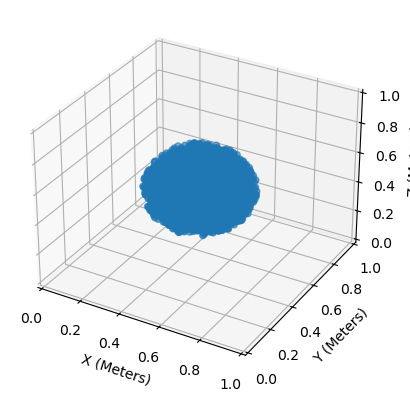

In [90]:
init_test.display_positions()

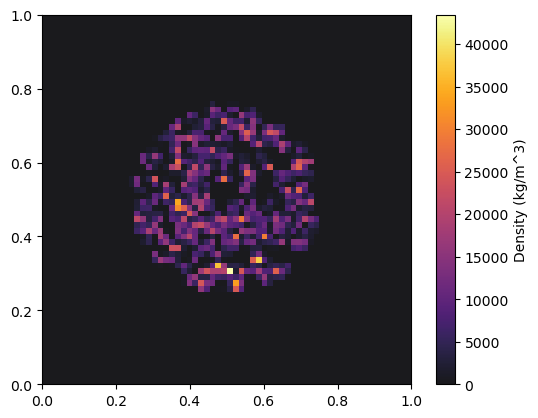

In [91]:
init_test.grid.display_density()

### Force Response Test

Next, comparing the result of the force calculations for both a single particle and an ensemble of particles.

The ensemble of $32^3$ particles will be re-used later for dynamics calculations.

The expected force field of the single particle is expected to be

$f(r) = \frac{GM}{r^2}$ with $GM = 6.67 \times 10^{-12}$.

The expected force field of the full sphere is expected to be

$f(r) = \begin{cases}
    \frac{GM}{r^2} & \text{if } r > R_S \\ 
    \frac{GM}{R^3} r & \text{otherwise}
\end{cases}$

with $GM = 6.67 \times 10^{-12}$.



In [196]:
# Force Test
# This test displays the magnitude of the force field 
# as a function of radial distance from the center of mass.

# Np: Total number of particles in the simulation.
# Nc: Number of cells on each dimension of the simulation space lattice. (m)
# s: RNG seed. 

Mp = 0.1
Nc = 128            # Number of cells in the simulation space lattice
s = 1000

Np = 1              
sp_test = GravitySimulation(Mp, RS, xc, Np, L, Nc, s)

Np = 32**3            
sim = GravitySimulation(Mp, RS, xc, Np, L, Nc, s)

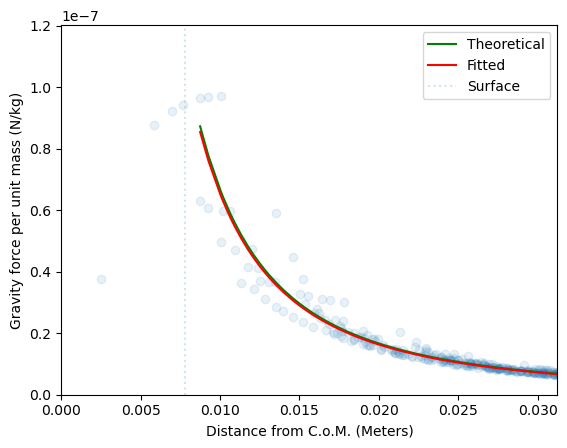

F_fit: 6.53e-12
 Expected: 6.67e-12


In [197]:
fit_forces = True  # Flag to show the theoretical expected force curve

sp_test.display_forces(fit_forces)

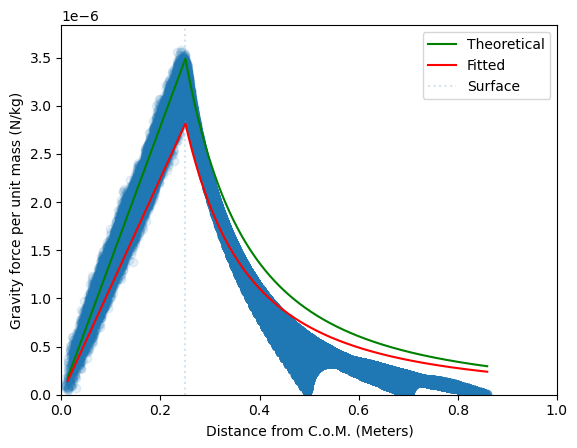

F_fit: 1.76e-07
 Expected: 2.19e-07


In [198]:
sim.display_forces(fit_forces)